In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl

In [2]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skopt
import skopt.plots
import scipy.optimize
import ipywidgets
from tqdm.auto import tqdm

In [3]:
dir_project = os.path.abspath('..')
dir_modules = os.path.join(dir_project, 'modules')
dir_scripts = os.path.join(dir_project, 'scripts')
dir_data = os.path.join(dir_project, 'data')
dir_data_aux = os.path.join(dir_project, 'data_aux')

In [4]:
sys.path.append(dir_modules)
import simulate
import stats_transcripts
import fitting
import utils_genomics

In [5]:
gene_length = 3640
pos_intron = np.array(
    [[ 828, 1135, 1669, 2363, 2579],
     [ 952, 1229, 2122, 2449, 3537]])
pos_exon = utils_genomics.pos_intron_to_pos_exon(pos_intron, gene_length)
time_points = np.array([0, 10, 15, 20, 25, 30, 45, 60, 75, 90, 120, 240]) * 60 + 600

In [6]:
param_names = ['k_init', 'k_decay', 'k_splice', 'k_elong']
n_introns = pos_intron.shape[1]
n_time_steps = time_points[-1]
time_steps = np.arange(1, n_time_steps + 1)
cols_introns = [f'intron{i}' for i in range(n_introns)]

# Interactively Plot Saved Simulations

In [10]:
params_all = np.load(os.path.join(dir_data_aux, 'sim', 'params.npy'))
params_to_index = {tuple(params_all[i]): i for i in range(len(params_all))}

## Using `ipywidgets` performantly

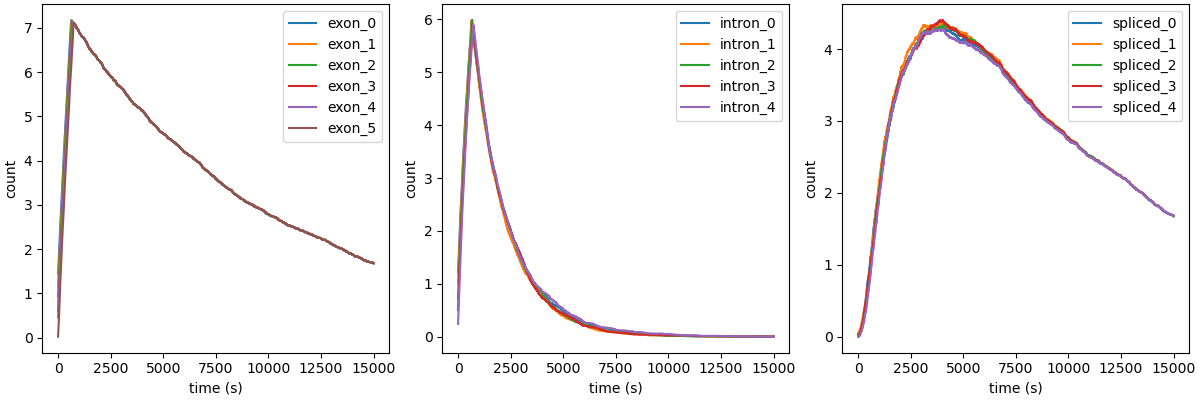

interactive(children=(SelectionSlider(description='k_init', options=(0.01, 0.1, 1.0, 10.0), value=0.01), Selec…

In [11]:
data = np.load(os.path.join(dir_data_aux, 'sim', 'junction_counts-0.npy'))
n_introns = data.shape[1] - 1
with plt.ioff():
    fig_interactive, axs_interactive = plt.subplots(1, 3, constrained_layout=True, sharex=True, figsize=(12, 4))
lines_exons, lines_introns, lines_spliced = [], [], []
for i in range(n_introns):
    lines_exons.extend(axs_interactive[0].plot(time_steps, data[:, i, 0], label=f'exon_{i}'))
    lines_introns.extend(axs_interactive[1].plot(time_steps, data[:, i, 1], label=f'intron_{i}'))
    lines_spliced.extend(axs_interactive[2].plot(time_steps, data[:, i, 2], label=f'spliced_{i}'))
lines_exons.extend(axs_interactive[0].plot(time_steps, data[:, i+1, 0], label=f'exon_{i+1}'))
for i in range(3):
    axs_interactive[i].legend()
    axs_interactive[i].set(xlabel='time (s)', ylabel='count')
fig_interactive.canvas.toolbar_position = 'top'
fig_interactive.show()

@ipywidgets.interact(
    **{param_name: ipywidgets.SelectionSlider(options=np.unique(params_all[:, i]))
       for i, param_name in enumerate(param_names)},
    autoscale_x=True,
    autoscale_y=True)
def update_data(k_init, k_decay, k_splice, k_elong, autoscale_x=True, autoscale_y=True):
    index = params_to_index[(k_init, k_decay, k_splice, k_elong)]
    data = np.load(os.path.join(dir_data_aux, 'sim', f'junction_counts-{index}.npy'))
    n_introns = data.shape[1] - 1
    for i in range(n_introns):
        lines_exons[i].set_data((time_steps, data[:, i, 0]))
        lines_introns[i].set_data((time_steps, data[:, i, 1]))
        lines_spliced[i].set_data((time_steps, data[:, i, 2]))
    lines_exons[i+1].set_data((time_steps, data[:, i+1, 0]))
    [ax.relim() for ax in fig_interactive.axes]
    if autoscale_x:
        # [ax.autoscale_view() for ax in fig.axes]
        [ax.autoscale(axis='x') for ax in fig_interactive.axes]
    if autoscale_y:
        [ax.autoscale(axis='y') for ax in fig_interactive.axes]
    fig_interactive.canvas.draw_idle()

## (Slow) Using `ipywidgets.interact`

In [ ]:
figs = []

In [ ]:
def f(k_init, k_decay, k_splice, k_elong):
    index = params_to_index[(k_init, k_decay, k_splice, k_elong)]
    data = np.load(os.path.join(dir_data_aux, 'sim', f'junction_counts-{index}.npy'))
    n_introns = data.shape[1] - 1
    (plt.close(fig) for fig in figs)
    with plt.ioff():
        fig, axs = plt.subplots(1, 3, constrained_layout=True, sharex=True, figsize=(12, 4))
    for i in range(n_introns):
        line = axs[0].plot(time_steps, data[:, i, 0], label=f'exon_{i}')
        axs[1].plot(time_steps, data[:, i, 1], label=f'intron_{i}')
        axs[2].plot(time_steps, data[:, i, 2], label=f'spliced_{i}')
    axs[0].plot(time_steps, data[:, i+1, 0], label=f'exon_{i+1}')
    for i in range(3):
        axs[i].legend()
        axs[i].set(xlabel='time (s)', ylabel='count')
    fig.canvas.toolbar_position = 'top'
    fig.show()
    figs.append(figs)
    return line

w = ipywidgets.interact(
    f,
    **{param_name: ipywidgets.SelectionSlider(options=np.unique(params_all[:, i])) for i, param_name in enumerate(param_names)})

# Interactively Plot New Simulations

In [7]:
# POU5F1, ENSMUSG00000024406
pos_intron2 = np.array([[ 467, 3207, 3522, 4123],
                        [3085, 3390, 3963, 4270]])
gene_length2 = 4755
n_introns2 = pos_intron2.shape[1]
pos_exon2 = utils_genomics.pos_intron_to_pos_exon(pos_intron2, gene_length2)

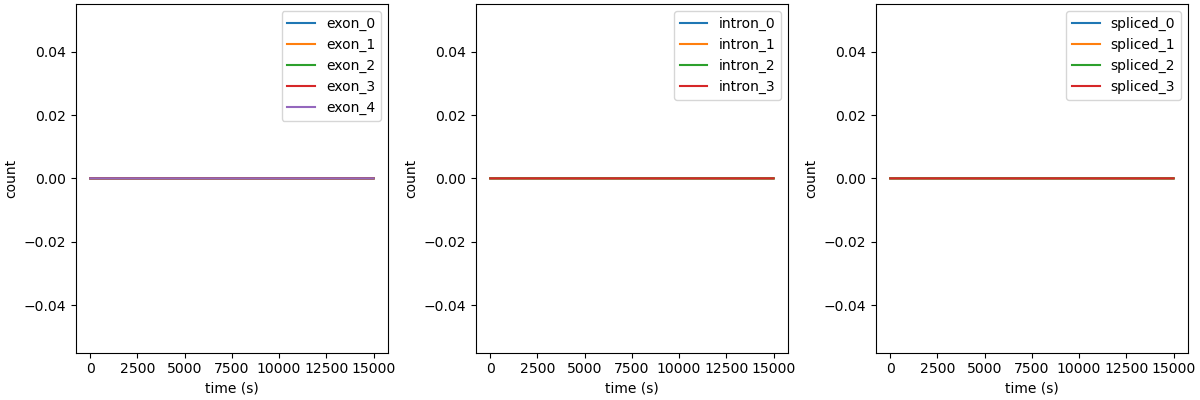

FloatText(value=0.0, description='k_init')

FloatText(value=0.0, description='k_decay')

FloatText(value=0.0, description='k_splice')

FloatText(value=0.0, description='k_elong')

interactive(children=(Checkbox(value=True, description='Autoscale x-axis'), Checkbox(value=True, description='…

interactive(children=(FloatLogSlider(value=0.1, description='k_init', max=2.0, min=-10.0, readout_format='e'),…

In [9]:
plt.close('all')
with plt.ioff():
    fig_interactive, axs_interactive = plt.subplots(1, 3, constrained_layout=True, sharex=True, figsize=(12, 4))
lines_exons, lines_introns, lines_spliced = [], [], []
for i in range(n_introns2):
    lines_exons.extend(axs_interactive[0].plot(time_steps, np.zeros_like(time_steps), label=f'exon_{i}'))
    lines_introns.extend(axs_interactive[1].plot(time_steps, np.zeros_like(time_steps), label=f'intron_{i}'))
    lines_spliced.extend(axs_interactive[2].plot(time_steps, np.zeros_like(time_steps), label=f'spliced_{i}'))
lines_exons.extend(axs_interactive[0].plot(time_steps, np.zeros_like(time_steps), label=f'exon_{i+1}'))
for i in range(3):
    axs_interactive[i].legend()
    axs_interactive[i].set(xlabel='time (s)', ylabel='count')
fig_interactive.canvas.toolbar_position = 'top'
fig_interactive.show()

xticks_orig = axs_interactive[0].get_xticks()
xticklabels_orig = axs_interactive[0].get_xticklabels()

widget_kinit_slider = ipywidgets.FloatLogSlider(base=10, value=0.1, min=-10, max=2, step=0.1, readout_format='e')
widget_kdecay_slider = ipywidgets.FloatLogSlider(base=10, value=0.01, min=-10, max=2, step=0.1, readout_format='e')
widget_ksplice_slider = ipywidgets.FloatLogSlider(base=10, value=0.01, min=-10, max=2, step=0.1, readout_format='e')
widget_kelong_slider = ipywidgets.FloatSlider(value=50, min=0, max=200, step=0.0001, readout_format='.4f')
widget_kinit_text = ipywidgets.FloatText(description='k_init')
widget_kdecay_text = ipywidgets.FloatText(description='k_decay')
widget_ksplice_text = ipywidgets.FloatText(description='k_splice')
widget_kelong_text = ipywidgets.FloatText(description='k_elong')
ipywidgets.jslink((widget_kinit_slider, 'value'), (widget_kinit_text, 'value'))
ipywidgets.jslink((widget_kdecay_slider, 'value'), (widget_kdecay_text, 'value'))
ipywidgets.jslink((widget_ksplice_slider, 'value'), (widget_ksplice_text, 'value'))
ipywidgets.jslink((widget_kelong_slider, 'value'), (widget_kelong_text, 'value'))
display(widget_kinit_text, widget_kdecay_text, widget_ksplice_text, widget_kelong_text)

widget_autoscalex = ipywidgets.Checkbox(value=True, description='Autoscale x-axis')
widget_autoscaley = ipywidgets.Checkbox(value=True, description='Autoscale y-axis')

@ipywidgets.interact(
    autoscale_x=widget_autoscalex,
    autoscale_y=widget_autoscaley,
    experimental_time=False)
def update_view(autoscale_x=True, autoscale_y=True, experimental_time=False):
    [ax.relim() for ax in fig_interactive.axes]
    if autoscale_x:
        # [ax.autoscale_view() for ax in fig.axes]
        [ax.autoscale(axis='x') for ax in fig_interactive.axes]
    if autoscale_y:
        [ax.autoscale(axis='y') for ax in fig_interactive.axes]
    if experimental_time:
        [ax.set_xticks(np.arange(0, n_time_steps, 2400)) for ax in fig_interactive.axes]
        [ax.set_xticklabels((ax.get_xticks() / 60 - 10).astype(int), ) for ax in fig_interactive.axes]
    else:
        [ax.set_xticks(xticks_orig) for ax in fig_interactive.axes]
        [ax.set_xticklabels(xticklabels_orig) for ax in fig_interactive.axes]
    fig_interactive.canvas.draw_idle()

@ipywidgets.interact(
    k_init=widget_kinit_slider,
    k_decay=widget_kdecay_slider,
    k_splice=widget_ksplice_slider,
    k_elong=widget_kelong_slider,
    n=ipywidgets.IntSlider(value=10, min=1, max=500, step=1, description='# simulations to average:'))
def update_data(k_init, k_decay, k_splice, k_elong, n):
    time_points, results = simulate.parallel_simulations(
        n,
        (k_init, k_decay, k_splice, k_elong), pos_intron2, gene_length2, n_time_steps, t_wash=600,
        stats_fun=stats_transcripts.junction_counts,
        stats_kwargs=dict(pos_exon=pos_exon2),
        log10=False,
        aggfun=simulate.mean,
        alt_splicing=False,
        verbose=False)
    for i in range(n_introns2):
        lines_exons[i].set_data((time_steps, results[:, i, 0]))
        lines_introns[i].set_data((time_steps, results[:, i, 1]))
        lines_spliced[i].set_data((time_steps, results[:, i, 2]))
    lines_exons[i+1].set_data((time_steps, results[:, i+1, 0]))
    update_view(widget_autoscalex.value, widget_autoscaley.value)

# Specific Simulations

## Effect of `k_elong` on timing of peak

In [7]:
params = [1, 0.003, 0.005, 50]
print('Time (s) to finish transcription:', gene_length / params[3])
print('Response time (s) to steady-state exon concentration:', round(np.log(2) / params[1], 2))

Time (s) to finish transcription: 72.8
Response time (s) to steady-state exon concentration: 231.05


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

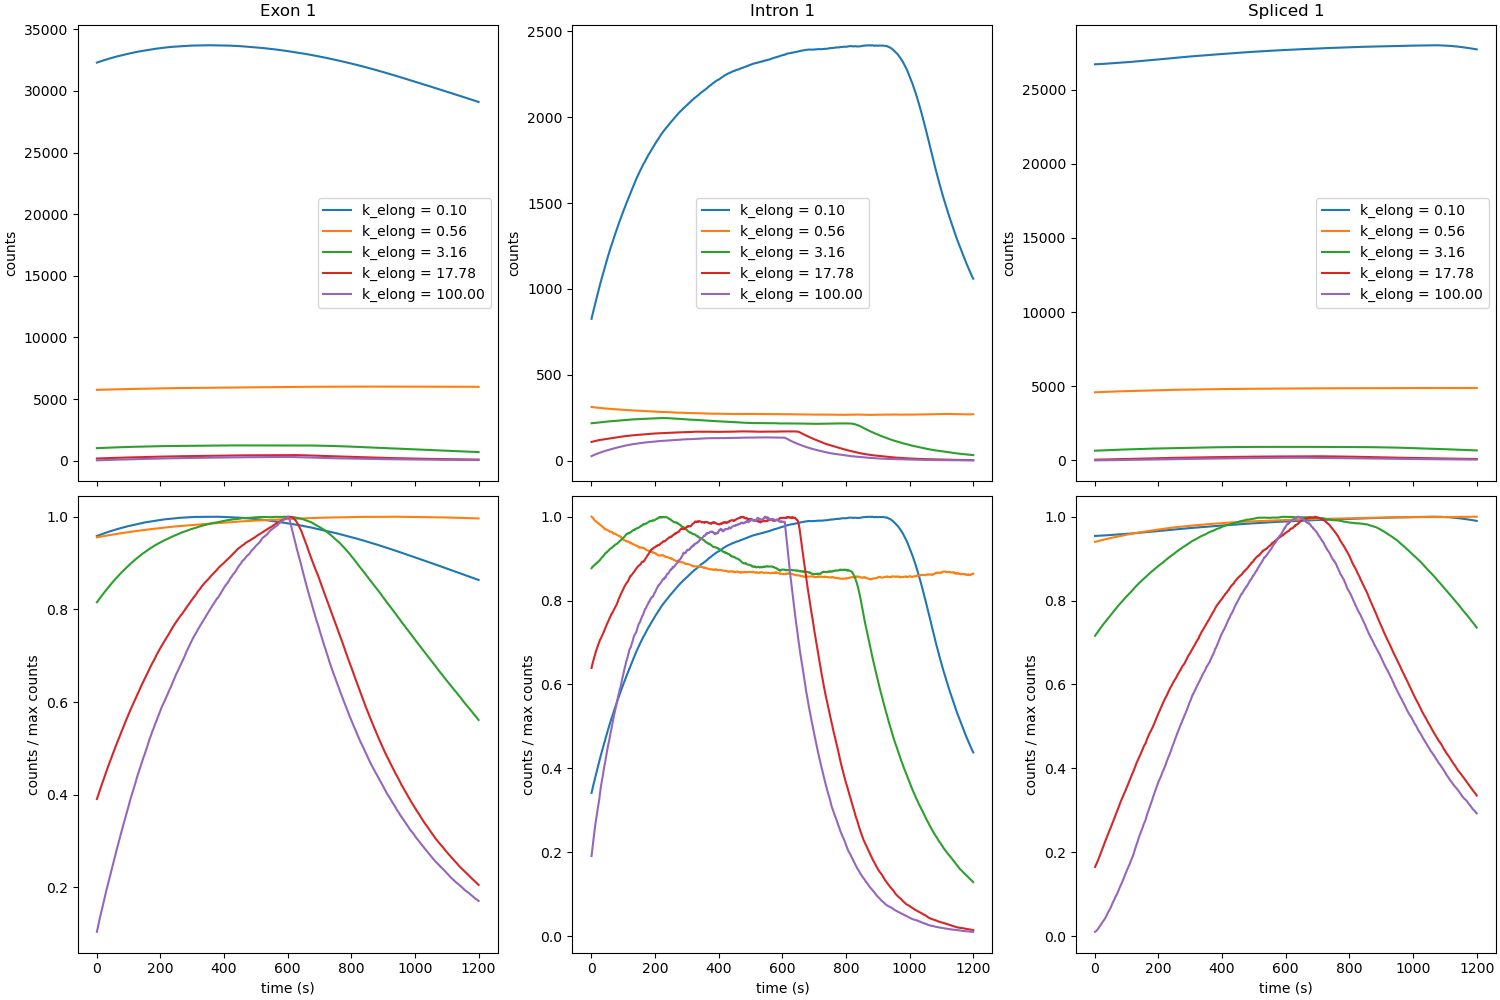

In [8]:
fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize=(15, 10), sharex=True, sharey=False)
for k_elong in np.logspace(-1, 2, 5):
    params[3] = k_elong
    time_points, result = simulate.parallel_simulations(
        100,
        params, pos_intron, gene_length, 1200, t_wash=600,
        stats_fun=stats_transcripts.junction_counts,
        stats_kwargs=dict(pos_exon=pos_exon),
        log10=False,
        aggfun=simulate.mean,
        alt_splicing=False,
        verbose=False)
    for i in range(3):
        axs[0, i].plot(time_points, result[:, 0, i], label=f'k_elong = {k_elong:.2f}')
        axs[1, i].plot(time_points, result[:, 0, i] / result[:, 0, i].max(), label=f'k_elong = {k_elong:.2f}')
for i in range(3):
    axs[0, i].legend()
    axs[0, i].set(title=('Exon 1', 'Intron 1', 'Spliced 1')[i], ylabel='counts')
    axs[1, i].set(xlabel='time (s)', ylabel='counts / max counts')